Code for the final project of CSE 468t by Deepthi Kailash and Thomas Westbrook

Brassard and Hoyer's Algorithm for Simon's Subgroup Problem: A 2-qubit example

In [200]:
#
# NOTE
# The below pieces of Brassard and Hoyer's algorithm draw some code
# directly from SimonAssignment.ipynb on Canvas.
#

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from qiskit import *
import numpy as np
import random
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import GroverOperator

%matplotlib inline
import matplotlib.pyplot as plt

# IBMQ.save_account('', overwrite = True)
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-07 23:09:59,871: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

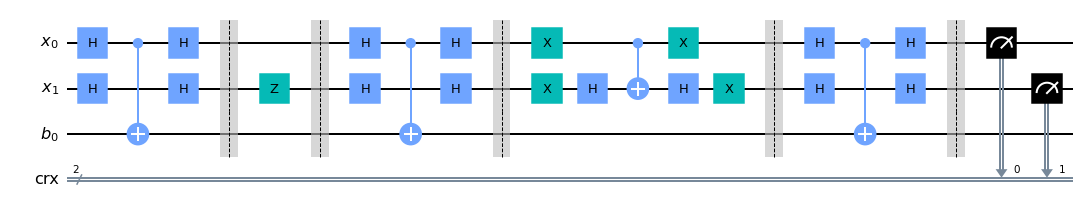

{'00': 251, '01': 261}

In [207]:
#
# StackOverflow 
# https://stackoverflow.com/questions/10321978/integer-to-bitfield-as-a-list
#
#  but reversed so the index is the bit position
#  and padded with the right number of leading zeros
#
def revbitfield(n, numbits):
    ans = [ 0 ] * numbits
    bits = [int(digit) for digit in bin(n)[2:]]# [2:] to chop off the "0b" part
    p = len(ans)-len(bits)
    for i in range(len(bits)):
        ans[i+p] = bits[i]
    return ans[::-1] # reverse

def rotate(qc, qr, theta):
    qc.u3(theta*2, 0, 0, qr)
    return qc

def applyInput(q, val):
    qc = q.qc
    qx = q.qx
    n = len(q.qx)
    bits = revbitfield(val, n)
    for i in range(n):
        if bits[i]==0:
            qc.iden(qx[i])
        else:
            qc.x(qx[i])
    return q

yList = []

class QC: # Copied from SimonAssignment.ipynb except for getqc()
    def __init__(self):
        self.qc = QuantumCircuit()

    def em(self, shots=512):
        em = BasicAer.get_backend("qasm_simulator")
        job = execute(self.qc, em, shots=shots)
        hist = job.result().get_counts()
        return hist
    
    def sv(self):
        svs = BasicAer.get_backend("statevector_simulator")
        job = execute(self.qc, svs)
        ket = job.result().get_statevector()
        return ket
   
    def draw(self, output='text'):
        return self.qc.draw(output=output)
    
    def barrier(self):
        self.qc.barrier()
        
    def getqc(self):
        return self.qc

class A_prime(QC): # Implementation of Simon's original algorithm combined with Lemma 7 in B&H
    def __init__(self, n):
        super().__init__()
        self.n = n
        self.qx = QuantumRegister(n, 'x')
        self.qc.add_register(self.qx)
        self.qb = QuantumRegister(1, 'b') # one output to match B&H
        self.qc.add_register(self.qb)
    
    def begin(self):
        n = self.n
        for i in range(n):
            self.qc.h(i)
        return self
        
    def Uf(self):   #   secret = 10
        self.qc.cx(self.qx[0],self.qb[0])
        return self
    
    def end(self):
        n = self.n
        qx = self.qx
        qc = self.qc
        qb = self.qb
        for i in range(n):
            qc.h(i)
        return self
    
    def simonsSubroutine(self):
        self.begin()
        self.Uf()
        self.end()
        
    def shrink(self):
        for y in yList:
            j = y.find('1')
            self.qc.cx(self.qx[self.n-1-j], self.qb[0])
            for i in range(len(y)):
                if y[i] == '1':
                    self.qc.cx(self.qb[0], self.qx[self.n-1-i])
            self.qc.h(self.qb[0])
                    
    def measure(self): # not used
        n = self.n
        qx = self.qx
        qc = self.qc
        qb = self.qb
        crb = ClassicalRegister(1, 'crb')
        qc.add_register(crb)
        qc.measure(qb[0],crb[0])
        self.qc.barrier()
        crx = ClassicalRegister(n, 'crx')
        qc.add_register(crx)
        for i in range(n):
            qc.measure(qx[i],crx[i])
        return self
        
    def make(self):
        self.simonsSubroutine()
        self.shrink()
        self.barrier()
        return self

class Q_i(QC): # Implementation of Lemma 8 in B&H
    
    def __init__(self, qubits = 2, index = 0):
        super().__init__()
        self.n = qubits
        self.i = index
        self.qx = QuantumRegister(self.n, 'x')
        self.qc.add_register(self.qx)
        self.qb = QuantumRegister(1, 'b') # one output to match B&H
        self.qc.add_register(self.qb)
        self.crx = ClassicalRegister(self.n, 'crx')
        self.qc.add_register(self.crx)
        
    def zeroPhaseShift(self): # S_{0} in the Grover iteration
        for i in range(self.n):
            self.qc.x(i)
        self.qc.h(self.n-1)
        self.qc.cx(0, self.n-1)
        for i in range(self.n-1):
            self.qc.x(i)
        self.qc.h(self.n-1)
        self.qc.x(self.n-1)
        self.barrier()
        
    def aPhaseShift(self, i): # S_A in the Grover iteration
        self.qc.z(self.n-1-i)
        
    def measure(self): # not used
        n = self.n
        qx = self.qx
        qc = self.qc
        qb = self.qb
        crx = self.crx
        for i in range(n):
            qc.measure(qx[i],crx[i])
        return self
        
    def make(self):
        self.qc = self.qc + A_prime(self.n).make().getqc() # A in Q_i = GA, G being the Grover iteration
        self.aPhaseShift(self.i)
        self.qc = self.qc + A_prime(self.n).make().getqc().inverse() # A^-1 in the Grover iteration
        self.barrier()
        self.zeroPhaseShift()
        self.qc = self.qc + A_prime(self.n).make().getqc() # A in the Grover iteration
        self.measure()
        return self
    
yList = []
    
def gen():
    return Q_i(qubits = 2, index = 0)

gen().make().draw(output='mpl')

gen().make().em(shots=512)